<a href="https://colab.research.google.com/github/pawaka2025/3DAlloc/blob/main/MST_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dependency Tree (Head -> Dependent):
ROOT -> the
ROOT -> cat
ROOT -> sleeps


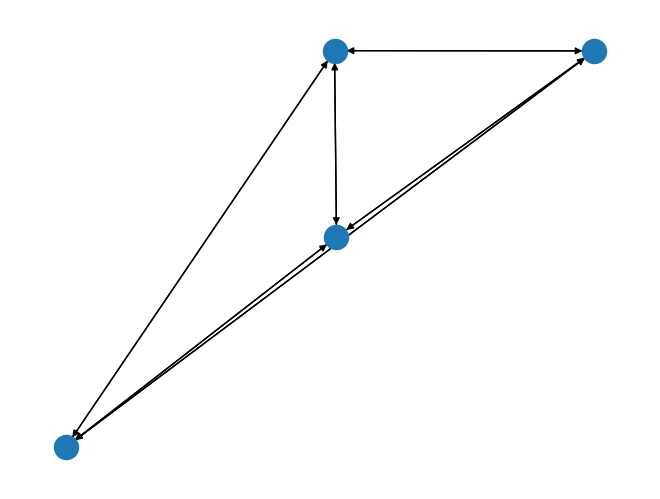

In [ ]:
# Method 1 : Use Edmond's algorthm

import torch
import networkx as nx

# Define sentence words (ROOT for the root node)
words = ["ROOT", "the", "cat", "sleeps"]

# Example adjacency matrix with weights
# Rows: Head, Columns: Dependent
# Higher weight means a stronger dependency relation
score_matrix = torch.tensor([
    [0.0, 0.5, 0.7, 0.8],  # ROOT -> (the, cat, sleeps)
    [0.0, 0.0, 0.7, 0.0],  # the -> (cat)
    [0.0, 0.0, 0.0, 0.2],  # cat -> (sleeps)
    [0.0, 0.0, 0.0, 0.0],  # sleeps -> (None)
])

# Crate a NetworkX graph
G = nx.DiGraph()

# Add edges with weights to the NetworkX graph
num_words = len(words)
for head in range(num_words):
    for dep in range(num_words):
        if head != dep:  # No self-loops
            G.add_edge(head, dep, weight=score_matrix[head, dep].item())

# Visualize the NetworkX graph for inspection (very crude, no labels for edges and nodes)
nx.draw(G)

# Compute Maximum Spanning Tree using Edmonds' algorithm
mst = nx.maximum_spanning_arborescence(G)

# Print dependencies
print("Dependency Tree (Head -> Dependent):")
for head, dep in mst.edges():
    print(f"{words[head]} -> {words[dep]}")


In [ ]:
import torch
# A more comprehensive grammar would look like this (assuming absolute values
# instead of probabilistic for weights)
score_matrix = torch.tensor([
    #  ROOT  the  cat  dog  tiger  lion  elephant  giraffe  monkey  horse  rabbit  sleeps
    [   0,    9,   0,   0,    0,    0,       0,       0,      0,      0,      0,     8],  # ROOT -> the, sleeps
    [   0,    0,  10,  10,   10,   10,      10,      10,     10,     10,     10,     0],  # the -> (any noun)
    [   0,    0,   0,   0,    0,    0,       0,       0,      0,      0,      0,    12],  # cat -> sleeps
    [   0,    0,   0,   0,    0,    0,       0,       0,      0,      0,      0,    12],  # dog -> sleeps
    [   0,    0,   0,   0,    0,    0,       0,       0,      0,      0,      0,    12],  # tiger -> sleeps
    [   0,    0,   0,   0,    0,    0,       0,       0,      0,      0,      0,    12],  # lion -> sleeps
    [   0,    0,   0,   0,    0,    0,       0,       0,      0,      0,      0,    12],  # elephant -> sleeps
    [   0,    0,   0,   0,    0,    0,       0,       0,      0,      0,      0,    12],  # giraffe -> sleeps
    [   0,    0,   0,   0,    0,    0,       0,       0,      0,      0,      0,    12],  # monkey -> sleeps
    [   0,    0,   0,   0,    0,    0,       0,       0,      0,      0,      0,    12],  # horse -> sleeps
    [   0,    0,   0,   0,    0,    0,       0,       0,      0,      0,      0,    12],  # rabbit -> sleeps
    [   0,    0,   0,   0,    0,    0,       0,       0,      0,      0,      0,     0],  # sleeps -> (None)
])


In [ ]:
# Method 2 : utilize sparse matrices + min-plus semiring

import numpy as np
from scipy.sparse import csr_matrix, csc_matrix

# Define sentence words (including ROOT node)
words = ["ROOT", "the", "cat", "sleeps"]

# Adjacency matrix representation of the graph
adj_matrix = np.array([
    [0.0, 1.0, 1.0, 1.0],  # ROOT -> (the, cat, sleeps)
    [0.0, 0.0, 1.0, 0.0],  # the -> (cat)
    [0.0, 0.0, 0.0, 1.0],  # cat -> (sleeps)
    [0.0, 0.0, 0.0, 0.0],  # sleeps -> (None)
], dtype=np.float32)

# Convert adjacency matrix to CSR (for A) and CSC (for B)
row_idx, col_idx = np.where(adj_matrix > 0)
data = adj_matrix[row_idx, col_idx]

A_csr = csr_matrix((data, (row_idx, col_idx)), shape=adj_matrix.shape)
B_csc = A_csr.tocsc()  # Convert to CSC format

print("CSR Representation (A):")
print(A_csr)

print("\nCSC Representation (B):")
print(B_csc)

# ---- Step 2: Semiring ----
def semiring_max_plus(A_csr, B_csc):
    """
    Perform min-plus semiring multiplication using sparse matrix formats:
    - A is in CSR (efficient row-wise access)
    - B is in CSC (efficient column-wise access)

    Computes: C_ij = min_k (A_ik + B_kj)
    """
    # Get sparse matrix data
    A_indptr, A_indices, A_data = A_csr.indptr, A_csr.indices, A_csr.data
    B_indptr, B_indices, B_data = B_csc.indptr, B_csc.indices, B_csc.data

    # Output shape
    n = A_csr.shape[0]
    C_data = []
    C_row = []
    C_col = []

    # Min-Plus sparse multiplication
    for i in range(n):  # Iterate over rows of A (CSR)
        for j in range(n):  # Iterate over columns of B (CSC)
            min_value = np.inf  # Start with infinity
            a_start, a_end = A_indptr[i], A_indptr[i+1]
            b_start, b_end = B_indptr[j], B_indptr[j+1]

            # Merge-scan over A[i, :] and B[:, j]
            ai, bi = a_start, b_start
            while ai < a_end and bi < b_end:
                a_k, b_k = A_indices[ai], B_indices[bi]

                if a_k == b_k:  # Matching column/row index
                    min_value = min(min_value, A_data[ai] + B_data[bi])
                    ai += 1
                    bi += 1
                elif a_k < b_k:
                    ai += 1
                else:
                    bi += 1

            if min_value < np.inf:
                C_data.append(min_value)
                C_row.append(i)
                C_col.append(j)

    return csr_matrix((C_data, (C_row, C_col)), shape=(n, n))

# ---- Step 3: Compute MST using Semiring ----
# Initially, distance matrix is the adjacency matrix
distance_matrix = A_csr.copy()

# Number of nodes
n_nodes = adj_matrix.shape[0]

# Iterate until convergence (or a fixed number of steps)
for _ in range(n_nodes - 1):
    distance_matrix = semiring_min_plus(distance_matrix, B_csc)

# ---- Step 4: Extract MST ----
mst_edges = []
csr_dense = distance_matrix.toarray()

for j in range(1, n_nodes):  # Exclude ROOT from being a dependent
    min_parent = np.argmin(csr_dense[:, j])  # Find the best parent for each node
    mst_edges.append((words[min_parent], words[j]))

# Print MST result
print("\nMinimum Spanning Tree (Head -> Dependent):")
for head, dep in mst_edges:
    print(f"{head} -> {dep}")


CSR Representation (A):
<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 5 stored elements and shape (4, 4)>
  Coords	Values
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (1, 2)	1.0
  (2, 3)	1.0

CSC Representation (B):
<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 5 stored elements and shape (4, 4)>
  Coords	Values
  (0, 1)	1.0
  (0, 2)	1.0
  (1, 2)	1.0
  (0, 3)	1.0
  (2, 3)	1.0

Minimum Spanning Tree (Head -> Dependent):
ROOT -> the
ROOT -> cat
ROOT -> sleeps


In [ ]:
x

TLDR; define every word as a node and connect the words to each other via edges. Weights = probability, useful when there are ambiguities with the meaning of words ie 'I resent the letter' or 'draw a square with 3 lines'.
Make an adjacency matrix for this.

Then there are two ways to do this:

1. Either do Edmund's algo.

2. Or represent the adjacency matrix as a CSR and CSC and then do semiring matmul using max and plus as monoids.

Both methods can be done while utilizing AVX-512 SIMD. (though 2 works better with SIMD)

Deeper dive:

MST with Structural Constraints – Add constraints that ensure the MST follows programming syntax (e.g., valid Python/JS/SQL AST structures). This could involve integrating MST with tree automata.